In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [2]:
dataset=pd.read_csv('datafinal.csv')

In [3]:
dataset

,Time,Generation_kW,FREQ,WP_AVG,TEMP_AVG,WS_AVG_10M,WS_AVG_50M,WS_AVG_80M,WS_AVG_100M
0,01-01-2019 00:00,139950.47,50.1537,1004.871333,7.133333,4.154667,7.131333,8.928000,9.783000
1,01-01-2019 00:15,147199.00,49.9505,1004.693000,7.033333,3.750333,6.916667,8.825000,9.665333
2,01-01-2019 00:30,150222.60,49.9242,1005.084333,6.900000,4.037333,7.281333,9.008000,9.608667
3,01-01-2019 00:45,153285.87,50.0297,1004.924333,6.800000,4.755667,7.660000,9.580667,9.902333
4,01-01-2019 01:00,158134.67,50.0240,1005.084333,6.633333,4.974333,7.651667,10.064000,10.355667
...,...,...,...,...,...,...,...,...,...
35035,31-12-2019 22:45,165488.13,50.0015,999.200000,23.300000,4.264333,9.217000,10.481667,9.910667
35036,31-12-2019 23:00,163082.27,50.0344,999.164333,23.266667,4.548333,9.294000,10.707000,10.552333
35037,31-12-2019 23:15,160880.20,50.0203,1006.933333,23.600000,4.146000,9.225667,10.584000,10.312667
35038,31-12-2019 23:30,157473.93,50.0402,1006.880000,23.400000,3.547333,9.076667,10.519000,10.234333


In [4]:
## dataset_testing is the dataset on which I will predict the values,i.e.,31st dec
dataset_training=dataset.iloc[:int(len(dataset)*0.9971465258952776), ]
dataset_testing=dataset.iloc[int(len(dataset)*0.9971465258952776):, ]
print('Training dataset shape',dataset_training.shape)
print('31st dec dataset shape',dataset_testing.shape)

Training dataset shape (34940, 9)
31st dec dataset shape (100, 9)


In [5]:
training_set=dataset_training.iloc[:, 1:2].values
training_set

array([[139950.47],
       [147199.  ],
       [150222.6 ],
       ...,
       [171741.93],
       [167849.21],
       [163911.53]])

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
training_set_scaled=scaler.fit_transform(training_set)
training_set_scaled

array([[0.70357346],
       [0.74001402],
       [0.75521457],
       ...,
       [0.86339877],
       [0.84382888],
       [0.82403297]])

In [7]:
## using timestamps as 60 to make the x_train in desired format
x_train=[]
y_train=[]
for i in range(60,len(dataset_training)):
    x_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i, 0])
x_train,y_train=np.array(x_train),np.array(y_train)

In [8]:
## reshaping the x_train
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
regressor=Sequential([
    LSTM(60,return_sequences=True,input_shape=(x_train.shape[1],1)),
    Dropout(0.3),
    LSTM(60,return_sequences=True),
    Dropout(0.3),

    LSTM(60,return_sequences=False),
    Dropout(0.3),
    Dense(1)
])
regressor.compile(optimizer='adam',loss='mean_squared_error')
regressor.fit(x_train,y_train,epochs=20,batch_size=4096)

Epoch 1/20
9/9 [==============================] - 32s 3s/step - loss: 0.0627
Epoch 2/20
9/9 [==============================] - 26s 3s/step - loss: 0.0245
Epoch 3/20
9/9 [==============================] - 26s 3s/step - loss: 0.0182
Epoch 4/20
9/9 [==============================] - 27s 3s/step - loss: 0.0159
Epoch 5/20
9/9 [==============================] - 27s 3s/step - loss: 0.0144
Epoch 6/20
9/9 [==============================] - 28s 3s/step - loss: 0.0133
Epoch 7/20
9/9 [==============================] - 33s 4s/step - loss: 0.0124
Epoch 8/20
9/9 [==============================] - 36s 4s/step - loss: 0.0116
Epoch 9/20
9/9 [==============================] - 35s 4s/step - loss: 0.0110
Epoch 10/20
9/9 [==============================] - 36s 4s/step - loss: 0.0104
Epoch 11/20
9/9 [==============================] - 35s 4s/step - loss: 0.0100
Epoch 12/20
9/9 [==============================] - 35s 4s/step - loss: 0.0095
Epoch 13/20
9/9 [==============================] - 35s 4s/step - loss: 0.

In [10]:
dataset_total =pd.concat((dataset_training['Generation_kW'],dataset_testing['Generation_kW']),axis=0)
inputs=dataset_total[len(dataset_total)-len(dataset_testing)-60:].values
inputs=inputs.reshape(-1,1)
inputs=scaler.transform(inputs)
x_test=[]
for i in range(60,160):
    x_test.append(inputs[i-60:i, 0])
x_test=np.array(x_test)

In [11]:
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [12]:
predicted=regressor.predict(x_test)

In [13]:
predicted=scaler.inverse_transform(predicted)
dataset_testing['Predicted']=predicted
final_visualization=pd.concat([dataset['Generation_kW'],dataset_testing['Generation_kW'],dataset_testing['Predicted']],axis=1)

<AxesSubplot:>

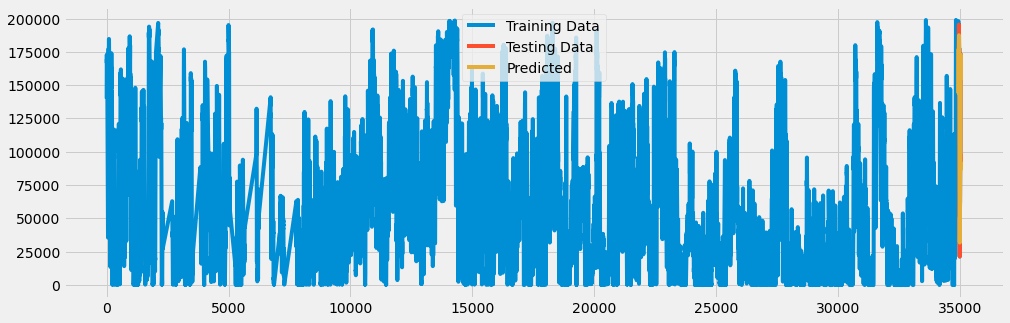

In [14]:
final_visualization.columns=['Training Data','Testing Data','Predicted']
final_visualization.plot(figsize=(15,5))

<AxesSubplot:>

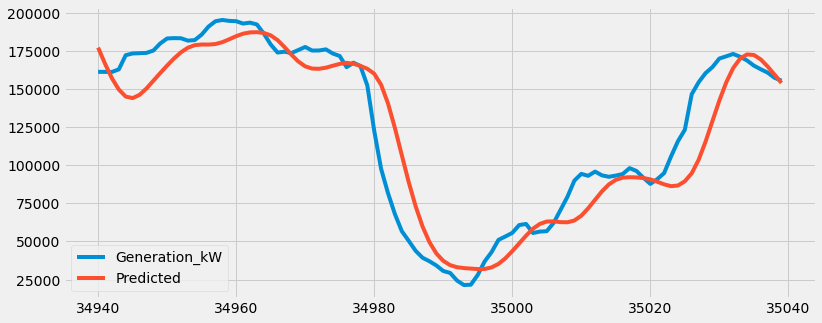

In [15]:
dataset_testing[['Generation_kW','Predicted']].plot(figsize=(12,5))

In [16]:
from sklearn.metrics import *

In [17]:
print(mean_absolute_error(dataset_testing['Generation_kW'],dataset_testing['Predicted']))
print(mean_squared_error(dataset_testing['Generation_kW'],dataset_testing['Predicted']))
print(np.sqrt(mean_squared_error(dataset_testing['Generation_kW'],dataset_testing['Predicted'])))

14363.5113375
397705968.37721944
19942.566744960877
